In [3]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
import numpy as np
import h5py
import pandas as pd
import cartopy.crs as ccrs
import geopandas as gpd
from shapely.geometry import Point

import rasterio
import tables as tab
import tqdm.notebook as tqdm
from skimage.transform import  AffineTransform
from rasterio.transform import Affine
from skimage.measure import ransac
from skimage.color import rgb2gray
from skimage.feature import match_descriptors, SIFT
from PIL import Image
import re
import math, requests
import io
import tqdm
import sys



from PRISMA_georeference import adjust_lat_lon, GoogleMapDownloader, GoogleMapsLayers, pixel_to_latlon, latlon_to_pix, prisma_2_tiff, match_subblocks

In [4]:
dir_path = r"C:\Users\simon\Documents\Skole\EIT\Tare_Naturbase"

In [5]:
filename = "HyperSpectral4.he5"

filename = dir_path + "/" + filename


with h5py.File(filename, mode='r') as f:
    # List available datasets.
    print(f.keys())
    print(type(f["HDFEOS INFORMATION"]))
    dset = f["HDFEOS"]
    print(dset.keys())

    info = f["Info"]["Ancillary"]
    print(info.keys())
    
    dataset = dset["SWATHS"]
    #dataset_L1 = dataset["PRS_L1_HCO"]["Geolocation Fields"]["Latitude_SWIR"]
    dataset_L1 = dataset["PRS_L1_HCO"]["Geolocation Fields"]

    print(dataset.keys())
    print(dataset_L1.keys())
    print(dataset_L1["Latitude_SWIR"][0:10])

<KeysViewHDF5 ['HDFEOS', 'HDFEOS INFORMATION', 'Info', 'KDP_AUX']>
<class 'h5py._hl.group.Group'>
<KeysViewHDF5 ['ADDITIONAL', 'SWATHS']>
<KeysViewHDF5 ['GyroData', 'PVSdata', 'StarTracker1', 'StarTracker2']>
<KeysViewHDF5 ['PRS_L1_HCO', 'PRS_L1_HRC', 'PRS_L1_PCO', 'PRS_L1_PRC']>
<KeysViewHDF5 ['Latitude_SWIR', 'Latitude_VNIR', 'Longitude_SWIR', 'Longitude_VNIR', 'Time']>
[[62.057938 62.057682 62.05743  ... 61.805214 61.80496  61.804707]
 [62.058025 62.057774 62.057518 ... 61.8053   61.805046 61.804794]
 [62.058117 62.05786  62.05761  ... 61.80539  61.805138 61.804882]
 ...
 [62.05856  62.058308 62.058052 ... 61.805832 61.80558  61.805325]
 [62.05865  62.058395 62.058144 ... 61.80592  61.805668 61.805412]
 [62.05874  62.058483 62.05823  ... 61.806007 61.805756 61.805504]]


In [6]:

with h5py.File(filename, mode='r') as f:
    print(f"Keys: {f.keys()}")
    for key in f.keys():
        print(key)
        print(f[key].keys())
    print(f["KDP_AUX"]["LOS_Pan"][0])

    print(f["HDFEOS"]["SWATHS"]["PRS_L1_HRC"]["Data Fields"].keys())
    print(f["HDFEOS"]["SWATHS"]["PRS_L1_HRC"]["Geolocation Fields"].keys())

Keys: <KeysViewHDF5 ['HDFEOS', 'HDFEOS INFORMATION', 'Info', 'KDP_AUX']>
HDFEOS
<KeysViewHDF5 ['ADDITIONAL', 'SWATHS']>
HDFEOS INFORMATION
<KeysViewHDF5 ['StructMetadata.0']>
Info
<KeysViewHDF5 ['Ancillary', 'Header', 'Housekeeping']>
KDP_AUX
<KeysViewHDF5 ['Cw_Swir_Matrix', 'Cw_Vnir_Matrix', 'Fwhm_Swir_Matrix', 'Fwhm_Vnir_Matrix', 'LOS_Pan', 'LOS_Swir', 'LOS_Vnir']>
[ 0.337853   -0.03228952  0.9406448 ]
<KeysViewHDF5 ['FrameNumber', 'SWIR_Cube', 'SWIR_PIXEL_SAT_ERR_MATRIX', 'VNIR_Cube', 'VNIR_PIXEL_SAT_ERR_MATRIX']>
<KeysViewHDF5 ['Latitude_SWIR', 'Latitude_VNIR', 'Longitude_SWIR', 'Longitude_VNIR', 'Time']>


In [7]:
with h5py.File(filename, mode='r') as f:
    data = np.array(f["HDFEOS"]["SWATHS"]["PRS_L1_HRC"]["Data Fields"]['VNIR_Cube'])
    lat = np.array(f["HDFEOS"]["SWATHS"]["PRS_L1_HRC"]['Geolocation Fields']['Latitude_VNIR'])
    lon = np.array(f["HDFEOS"]["SWATHS"]["PRS_L1_HRC"]['Geolocation Fields']['Longitude_VNIR'])

In [8]:
coord = np.array([lat,lon]).T
coord.shape

adjusted = np.load('out/out4.npy')
adjusted.shape



(1000, 1000, 2)

In [9]:
data_with_coord = np.zeros((1000,1000,66+2))

In [10]:
data_with_coord[:,:,:66] = np.transpose(data,[0,2,1])
data_with_coord[:,:,66:] = adjusted

In [11]:
data_with_coord.shape


(1000, 1000, 68)

In [12]:
RGB = np.dstack((data_with_coord[:,:,33] , data_with_coord[:,:,45] , data_with_coord[:,:,56]))

In [13]:
def normalise(pic):
  max = pic.max()
  min = pic.min()
  new = (pic - min)/(max-min)
  return new

In [14]:
RGB = normalise(RGB)

In [34]:
columns = [f"band_{i+1}" for i in range(66)]
columns.append("lon")
columns.append("lat")
columns

['band_1',
 'band_2',
 'band_3',
 'band_4',
 'band_5',
 'band_6',
 'band_7',
 'band_8',
 'band_9',
 'band_10',
 'band_11',
 'band_12',
 'band_13',
 'band_14',
 'band_15',
 'band_16',
 'band_17',
 'band_18',
 'band_19',
 'band_20',
 'band_21',
 'band_22',
 'band_23',
 'band_24',
 'band_25',
 'band_26',
 'band_27',
 'band_28',
 'band_29',
 'band_30',
 'band_31',
 'band_32',
 'band_33',
 'band_34',
 'band_35',
 'band_36',
 'band_37',
 'band_38',
 'band_39',
 'band_40',
 'band_41',
 'band_42',
 'band_43',
 'band_44',
 'band_45',
 'band_46',
 'band_47',
 'band_48',
 'band_49',
 'band_50',
 'band_51',
 'band_52',
 'band_53',
 'band_54',
 'band_55',
 'band_56',
 'band_57',
 'band_58',
 'band_59',
 'band_60',
 'band_61',
 'band_62',
 'band_63',
 'band_64',
 'band_65',
 'band_66',
 'lon',
 'lat']

In [35]:
data_with_coord[0]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.68900000e+03, 6.20583289e+01, 5.13438581e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.68900000e+03, 6.20580741e+01, 5.13419709e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.95600000e+03, 6.20578232e+01, 5.13400887e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.37200000e+03, 6.18055434e+01, 4.94641705e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.54400000e+03, 6.18052887e+01, 4.94622881e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.67800000e+03, 6.18050377e+01, 4.94604011e+00]])

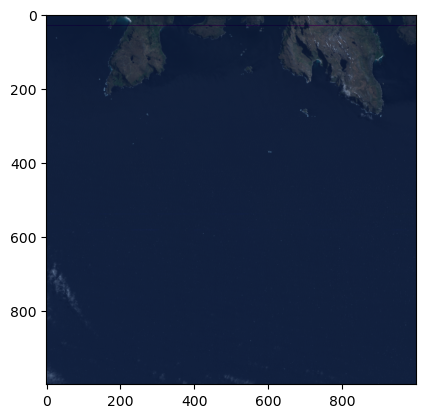

In [36]:
plt.imshow(RGB)

In [37]:
data_with_coord.shape

(1000, 1000, 68)

In [38]:
data_for_dataframe = data_with_coord.reshape(1000000, 68)

In [39]:
df = pd.DataFrame(data_for_dataframe, columns=columns)

In [40]:
df[["band_5", "lon", "lat"]]

,band_5,lon,lat
0,181.0,62.058329,5.134386
1,181.0,62.058074,5.134197
2,200.0,62.057823,5.134009
3,162.0,62.057568,5.133820
4,239.0,62.057314,5.133631
...,...,...,...
999995,154.0,61.892944,4.403368
999996,67.0,61.892693,4.403179
999997,111.0,61.892439,4.402991
999998,62.0,61.892184,4.402802


In [41]:
lat = df.lon.array
lon = df.lat.array
value = df.band_4.array
value
bands = df.columns[:-2]
bands

Index(['band_1', 'band_2', 'band_3', 'band_4', 'band_5', 'band_6', 'band_7',
       'band_8', 'band_9', 'band_10', 'band_11', 'band_12', 'band_13',
       'band_14', 'band_15', 'band_16', 'band_17', 'band_18', 'band_19',
       'band_20', 'band_21', 'band_22', 'band_23', 'band_24', 'band_25',
       'band_26', 'band_27', 'band_28', 'band_29', 'band_30', 'band_31',
       'band_32', 'band_33', 'band_34', 'band_35', 'band_36', 'band_37',
       'band_38', 'band_39', 'band_40', 'band_41', 'band_42', 'band_43',
       'band_44', 'band_45', 'band_46', 'band_47', 'band_48', 'band_49',
       'band_50', 'band_51', 'band_52', 'band_53', 'band_54', 'band_55',
       'band_56', 'band_57', 'band_58', 'band_59', 'band_60', 'band_61',
       'band_62', 'band_63', 'band_64', 'band_65', 'band_66'],
      dtype='object')

In [42]:
for band in bands:
    value = df[band].array

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
    # Plot the map projection
    ax.set_extent([min(lon), max(lon), min(lat), max(lat)], crs=ccrs.Mercator())

    # Plot the latitude and longitude values, with the color of the marker indicating the data value
    scatter = ax.scatter(lon, lat, c=value, cmap='viridis', transform=ccrs.Mercator())

    # Add a colorbar to the plot
    plt.colorbar(scatter)

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    """ ax.set_xticks(np.arange(int(min(lon)), int(max(lon)) + 1, 1))
    ax.set_yticks(np.arange(int(min(lat)), int(max(lat)) + 1, 1))
    ax.set_xticklabels(np.arange(int(min(lon)), int(max(lon)) + 1, 1))
    ax.set_yticklabels(np.arange(int(min(lat)), int(max(lat)) + 1, 1)) """
    """ ax.set_xticks(np.arange(np.min(lon), np.max(lon)+1, 0.1))
    ax.set_yticks(np.arange(np.min(lat), np.max(lat)+1, 0.1))
    ax.set_xticklabels(np.arange(np.min(lon), np.max(lon)+1, 0.1))
    ax.set_yticklabels(np.arange(np.min(lat), np.max(lat)+1, 0.1)) """

    #ax.invert_yaxis()

    # Show the plot
    plt.savefig(f"out/{band}_he4.png")
    #plt.show()

KeyboardInterrupt: 

In [15]:
### Function for converting the PRISMA file to a .tiff

def prisma_2_tiff( prisma_path, tiff_output, bandforRGB = 20 ):
    # this function converts a PRISMA image to a geotiff file
    # note that it also fixes a bug in the orientation of the PRISMA image
    file1 = tab.open_file(prisma_path)
    d2 = file1.get_node("/HDFEOS/SWATHS/PRS_L1_HRC/")
    latv = np.array(d2['Geolocation Fields']['Latitude_VNIR'])
    lonv = np.array(d2['Geolocation Fields']['Longitude_VNIR'])
    vnir = d2['Data Fields']['VNIR_Cube'][:,bandforRGB,:]
    file1.close()
    
    lat_centered= latv - latv.mean()
    lat_rescaled = lat_centered / lat_centered.max()
    
    lon_centered= lonv - lonv.mean()
    lon_rescaled = lon_centered / -lon_centered.min()
    
    angle = np.arctan2(lat_rescaled, lon_rescaled, dtype=np.float32)
    
    x = np.linspace(-1, 1, 1000)
    y = np.linspace(-1, 1, 1000)
    coords = np.array(np.meshgrid(x, y), dtype=np.float32).transpose((1, 2, 0))
    
    theta = -angle[500,0] + np.pi/2
    r = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    c2 = coords @ r
    
    base_factor = np.array([lat_centered.max(), lon_centered.max()])
    fudge_factor = np.array([c2[:,:,0].max(), -c2[:,:,1].max()]) # this is done because the input lat/lon are transposed
    rescale_factor = base_factor/fudge_factor
    
    means = np.array([latv.mean(), lonv.mean()])
    
    x = np.arange(1000, dtype=np.float32)
    y = np.arange(1000, dtype=np.float32)
    coords = np.array(np.meshgrid(x, y), dtype=np.float32).transpose((1, 2, 0))
    
    to_normalized = Affine.scale(1/500, 1/500)*Affine.translation(-500, -500)
    rot = Affine.rotation(-angle[0,500]*180/np.pi )
    from_normalized = Affine.translation(*(means[::-1]))*Affine.scale(*(rescale_factor[::-1]))#*
    transform = from_normalized*rot*to_normalized
    
    lon, lat = transform * coords.transpose(2, 0, 1)
    
    with rasterio.open(
        tiff_output,
        mode="w",
        driver="GTiff",
        height=lat.shape[0],
        width=lat.shape[1],
        count=3,
        dtype=lat.dtype,
        crs="+proj=latlong",
        transform=transform,
    ) as new_dataset:
        new_dataset.write(vnir, 1)
        new_dataset.write(lat, 2)
        new_dataset.write(lon, 3)
        
    return latv.mean(), lonv.mean()

In [16]:
latv, lonv = prisma_2_tiff(filename, "prisma.tif")

In [17]:

MATCHING_CUTOFF = 0.7
SEP_CUTOFF = 0.01

In [18]:
def adjust_lat_lon(path_to_PRISMA_file, bandforRGB, outpath=""):
    '''
    path_to_PRISMA_file - should be the full path so that re works
    '''
    zoom_level = 11
    tile_width = 7
    tile_height = 7
    
    
    metrics = {}
    print("# 1 create .tif file")
    tiff_output = outpath + '.tif'
    mean_lat, mean_lon = prisma_2_tiff(path_to_PRISMA_file, tiff_output, bandforRGB=bandforRGB)
    
    print("# 2 Download gmaps for the same location")
    gmd = GoogleMapDownloader(mean_lat, mean_lon, zoom_level,
                              GoogleMapsLayers.SATELLITE)
    img, tile_coords_corner = gmd.generateImage(tile_width=tile_width,
                                                tile_height=tile_height)
    
    print(" 3 Determine matched features in PRISMA image to gMaps image with SIFT")
    tif_coords, gmaps_coords, nmatches = \
        match_subblocks(tiff_output, tile_coords_corner, img, cutoff=MATCHING_CUTOFF)
    metrics['n_matches'] = nmatches
    del img
    
    orig_errs = np.sqrt(np.sum((tif_coords-gmaps_coords)**2, axis=1))
    metrics['orig_mean_error'] = orig_errs.mean()
    
    keep = orig_errs < SEP_CUTOFF
    src = np.array(tif_coords[keep])
    dst = np.array(gmaps_coords[keep])
    
    
    print(" 4 Define mapping between PRISMA LatLon and gMaps latlon")
    mapping, inliers = ransac((src, dst), AffineTransform, min_samples=4,
                               residual_threshold=0.002, max_trials=100)
    new_errs = np.sqrt(np.sum((mapping(src)-dst)**2, axis=1))
    metrics['new_mean_error'] = new_errs.mean()
    
    n_outliers = np.sum(~inliers)
    metrics['n_outliers'] = n_outliers
    
    print(" 5 Map PRISMA Latlons to gMaps latlons (ransac affine) and save for reference")
    orig = rasterio.open(tiff_output)
    adjusted_latlon = mapping(np.vstack([orig.read(2).flatten(),
                                        orig.read(3).flatten()]).transpose())
    orig.close()
    adjusted_latlon = adjusted_latlon.reshape((1000,1000,2))
    #np.savez(outpath + "_adjll.npz", adjusted_latlon = adjusted_latlon)
    np.save(outpath + ".npy", adjusted_latlon)
    return adjusted_latlon, metrics
  

In [19]:
class GoogleMapsLayers:
    ROADMAP = "v"
    TERRAIN = "p"
    ALTERED_ROADMAP = "r"
    SATELLITE = "s"
    TERRAIN_ONLY = "t"
    HYBRID = "y"

In [20]:
def pixel_to_latlon(px_x, px_y, tl_x, tl_y, zoom_level):
        """
            px_x, px_y: Pixel indices of google maps image
            tl_x, tl_y: tile indices of top left (noth-western) corner
            zoom_level: zoom level of the image

            returns: lat,lon
        """
        # background:
        # https://developers.google.com/maps/documentation/javascript/coordinates
        # https://en.wikipedia.org/wiki/Web_Mercator_projection

        tile_size = 256

        world_coord_x = (tile_size*tl_x + px_x) / 2**zoom_level
        world_coord_y = (tile_size*tl_y + px_y) / 2**zoom_level
        
        print(world_coord_x, world_coord_y)

        lon = (2.0*math.pi*world_coord_x / 256.0 - math.pi) * 180.0 / math.pi
        lat = (2.0*math.atan(math.e**math.pi * math.e**(- 2.0*math.pi*world_coord_y / 256.0)) - math.pi/2.0) * 180.0 / math.pi

        return lat,lon

In [21]:
class GoogleMapDownloader:
    """
        A class which generates high resolution google maps images given
        a longitude, latitude and zoom level
    """

    def __init__(self, lat, lng, zoom=12, layer=GoogleMapsLayers.ROADMAP):
        """
            GoogleMapDownloader Constructor
            Args:
                lat:    The latitude of the location required
                lng:    The longitude of the location required
                zoom:   The zoom level of the location required, ranges from 0 - 23
                        defaults to 12
        """
        self._lat = lat
        self._lng = lng
        self._zoom = zoom
        self._layer = layer

    def getXY(self):
        """
            Generates an X,Y tile coordinate based on the latitude, longitude
            and zoom level
            Returns:    An X,Y tile coordinate
        """

        tile_size = 256

        # Use a left shift to get the power of 2
        # i.e. a zoom level of 2 will have 2^2 = 4 tiles
        numTiles = 1 << self._zoom

        # Find the x_point given the longitude
        point_x = (tile_size / 2 + self._lng * tile_size / 360.0) * numTiles // tile_size

        # Convert the latitude to radians and take the sine
        sin_y = math.sin(self._lat * (math.pi / 180.0))

        # Calulate the y coorindate
        point_y = ((tile_size / 2) + 0.5 * math.log((1 + sin_y) / (1 - sin_y)) * -(
        tile_size / (2 * math.pi))) * numTiles // tile_size

        return int(point_x), int(point_y)


    def generateImage(self, **kwargs):
        """
            Generates an image by stitching a number of google map tiles together.
            Args:
                start_x:        The top-left x-tile coordinate
                start_y:        The top-left y-tile coordinate
                tile_width:     The number of tiles wide the image should be -
                                defaults to 5
                tile_height:    The number of tiles high the image should be -
                                defaults to 5
            Returns:
                A high-resolution Goole Map image.
        """

        start_x = kwargs.get('start_x', None)
        start_y = kwargs.get('start_y', None)
        tile_width = kwargs.get('tile_width', 16)
        tile_height = kwargs.get('tile_height', 16)

        # Check that we have x and y tile coordinates
        if start_x == None or start_y == None:
            start_x, start_y = self.getXY()
        # Determine the size of the image
        width, height = 256 * tile_width, 256 * tile_height
        # Create a new image of the size require
        j = 1
        map_img = Image.new('RGB', (width, height))
        for x in range(-tile_width//2, tile_width//2 + 1):
            for y in range(-tile_height//2, tile_height//2 +1):
                url = f'https://mt0.google.com/vt?lyrs={self._layer}&x=' + str(start_x + x) + \
                       '&y=' + str(start_y + y) + '&z=' + str(self._zoom)
                current_tile = str(x) + '-' + str(y)
                response = requests.get(url, stream=True)
                current_tile_pseudofile = io.BytesIO(response.raw.read())
                im = Image.open(current_tile_pseudofile)
                map_img.paste(im, ((x+tile_width//2) * 256, (y+tile_height//2) * 256))
        print('Image size (pix): ', map_img.size)
        tile_coords_corner = start_x-tile_width//2, start_y-tile_height//2
        print(f'Tile coordinate top left (north-west) corner: {tile_coords_corner[0]},{tile_coords_corner[1]}')
        return map_img, (tile_coords_corner)


In [28]:
def latlon_to_pix(lat, lon, tl_x, tl_y, zoom_level):
    """
        lat, lon: you know
        tl_x, tl_y: tile indices of top left (noth-western) corner
        zoom_level: zoom level of the image

        returns: pixelx pixely
    """
    # background:
    # https://developers.google.com/maps/documentation/javascript/coordinates
    # https://en.wikipedia.org/wiki/Web_Mercator_projection

    tile_size = 256

    world_coord_x = 128*(lon/180+1)
    world_coord_y = (math.pi-np.log(np.tan(math.pi/360*lat+math.pi/4)))*128/(math.pi)
    
    px = 2**zoom_level*world_coord_x - tile_size*tl_x
    py = 2**zoom_level*world_coord_y - tile_size*tl_y
    #print(world_coord_x, world_coord_y)

    #lon = (2.0*math.pi*world_coord_x / 256.0 - math.pi) * 180.0 / math.pi
    #lat = (2.0*math.atan(math.e**math.pi * math.e**(- 2.0*math.pi*world_coord_y / 256.0)) - math.pi/2.0) * 180.0 / math.pi

    return px, py


In [29]:
def match_subblocks(tiff_file, tile_coords_corner, gmap_img, cutoff=MATCHING_CUTOFF):
    blocks = [[[100*i,100*(i+2)-1],[100*j,100*(j+2)-1]] for i in range(9) for j in range(9)]
    
    # get the gmaps image
    gm0 = rgb2gray(gmap_img)
    gm0 = gm0 - gm0.min()
    gm0 /= gm0.max()
    
    # open the tiff file
    orig = rasterio.open(tiff_file)
    pim = np.log(orig.read(1)) - np.log(orig.read(1)).min()
    pim /= pim.max()
    
    nmatches = []
    lla = []
    llb = []
    
    for i in tqdm.tqdm(blocks):
    # determine bounds for PRISMA sub-image
        bounds = [
            [i[0][0],i[1][0]],
            [i[0][1],i[1][0]],
            [i[0][1],i[1][1]],
            [i[0][0],i[1][1]]
        ]

        # determine relevant portion of Gmaps to compare
        def k1_ll(px, py):
            return orig.read(2)[px, py], orig.read(3)[px, py]

        def k2_ll(px, py):
            latlon = pixel_to_latlon(px,py, *tile_coords_corner ,11)
            return latlon

        pbounds = []
        for bound in bounds:
            pbounds.append(latlon_to_pix(*k1_ll(*bound), *tile_coords_corner,11))
        pbounds = np.array(pbounds)
        
        xstart, xend = int(np.floor(pbounds[:,0].min())), int(np.ceil(pbounds[:,0].max()))
        ystart, yend = int(np.floor(pbounds[:,1].min())), int(np.ceil(pbounds[:,1].max()))

        # plot the two maps side by side (and rotated!)
        #fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        #ax[0].imshow(pim[i[0][0]:i[0][1],i[1][0]:i[1][1]])
        #ax[1].imshow(np.rot90(gm0[ystart:yend,xstart:xend]))
        #plt.show()

        # extract descriptors for matching images
        descriptor_extractor = SIFT()
        try: #to deal with runtime errors which can be generated by SIFT
            descriptor_extractor.detect_and_extract(pim[i[0][0]:i[0][1],i[1][0]:i[1][1]])
            keypoints1 = descriptor_extractor.keypoints
            descriptors1 = descriptor_extractor.descriptors
            descriptor_extractor.detect_and_extract((gm0[ystart:yend,xstart:xend]))
            keypoints2 = descriptor_extractor.keypoints
            descriptors2 = descriptor_extractor.descriptors

            matches12 = match_descriptors(descriptors1, descriptors2, max_ratio=cutoff,
                                  cross_check=True)
            
            
            #print("{} matches!".format(len(matches12)))

            # define local distance metrics
            def k2_ll(px, py):
                # not sure why the x and y coordinates switch here
                latlon = pixel_to_latlon(py + xstart ,px + ystart,
                                         *tile_coords_corner ,11)
                return latlon

            def k1_ll(px, py):
                px = px + i[0][0]
                py = py + i[1][0]
                return orig.read(2)[px, py], orig.read(3)[px, py]

            # check to see how close the points are in lat/lon, should usually have .00x accuracy

            for pair in matches12:
                ll1 = k1_ll(*keypoints1[pair[0]])
                lla.append(ll1)
                ll2 = k2_ll(*keypoints2[pair[1]])
                llb.append(ll2)

            nmatches.append(len(matches12))
        except RuntimeError:
            pass
        
    lla = np.array(lla)
    llb = np.array(llb)
    return lla, llb, nmatches    

In [38]:
prisma_path = "HyperSpectral4.he5"
prisma_path = dir_path + "/" + prisma_path
outpath = "out/out3"
outpath = "data_for_malan/HyperSpectral4_band_550"

for i in range(66):

    outpath = f"data_for_malan/HyperSpectral4_band_{400 + 10*i}"

    try:
        adjusted = adjust_lat_lon(prisma_path, outpath, 30)
        np.save(f"data_for_malan/Hyperspectral4_band_{400 + 10*i}.npy")
        
    except:
        print(f"Band {i} did not work")




Band 0 did not work
Band 1 did not work
Band 2 did not work
Band 3 did not work
Band 4 did not work
Band 5 did not work
Band 6 did not work
Band 7 did not work
Band 8 did not work
Band 9 did not work
Band 10 did not work
Band 11 did not work
Band 12 did not work
Band 13 did not work
Band 14 did not work
Band 15 did not work
Band 16 did not work
Band 17 did not work
Band 18 did not work
Band 19 did not work
Band 20 did not work
Band 21 did not work
Band 22 did not work
Band 23 did not work
Band 24 did not work
Band 25 did not work
Band 26 did not work
Band 27 did not work
Band 28 did not work
Band 29 did not work
Band 30 did not work
Band 31 did not work
Band 32 did not work
Band 33 did not work
Band 34 did not work
Band 35 did not work
Band 36 did not work
Band 37 did not work
Band 38 did not work
Band 39 did not work
Band 40 did not work
Band 41 did not work
Band 42 did not work
Band 43 did not work
Band 44 did not work
Band 45 did not work
Band 46 did not work
Band 47 did not work
Ba

In [26]:
adjusted[0].shape

(1000, 1000, 2)

In [ ]:
np.save("out/out4.npy", adjusted[0])

In [ ]:
#adjusted = np.load("out_adjll.npz")
adjusted = np.load('out/out4.npy')
adjusted.shape


In [ ]:
from rasterio.plot import show
with rasterio.open("out/out4.tif") as src:
    fig, ax = plt.subplots()

    # transform rasterio plot to real world coords
    extent=[src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3]]
    ax = rasterio.plot.show(src, extent=extent, ax=ax, cmap='pink')
    src.close()

In [ ]:
data_with_coord[:,:,66:] = adjusted